In [1]:
import numpy as np
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image

In [2]:
# Set Important Values

data = '/data/dww78/mini_inat_val/'
gpu = 1
torch.cuda.set_device(gpu)
workers = 8
epoch = 10
start_epoch = 0
vbity = 20
esize = 2

way = 20
evalway = 5
trainshot = 5
testshot = 15

In [3]:
# Load Training/Testing Data
threshold = .15
d_train = torch.load(data+'train_boxes.pth')
d_test = torch.load(data+'val_boxes.pth')
d_boxes = torch.load(data+'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, pathdict, boxdict, transform, size, msize, flipping, masking):
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    w,h = p.size
    p = p.resize((size, size), Image.BILINEAR)
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    if masking:
        mask = np.zeros((h,w))
        boxes = pathdict[path]
        for b in boxes:
            box = boxdict[b]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            if not flip or not flipping:
                mask[ymin:ymax, xmin:xmax] = 1
            else:
                mask[ymin:ymax, w-xmax:w-xmin] = 1
        mask = resize(mask, (msize,msize), mode='constant', cval=0, anti_aliasing=False)
        t = [t, (torch.FloatTensor(mask-threshold).sign()/2+.5).unsqueeze(0)]
    return t

class ProtoSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
#         for key in trackdict:
#             np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        while len(trackdict.keys()) >= self.way:
#             cats = np.random.choice(list(trackdict.keys()), size=self.way, replace=False)
            cats = list(trackdict.keys())[:self.way]
            for cat in cats:
                for _ in range(trainshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(testshot):
                    idlist.append(trackdict[cat].pop())
                if len(trackdict[cat]) < trainshot+testshot:
                    trackdict.pop(cat)
            # TODO: shuffle idlist batches
            yield idlist
            idlist = []

train_dataset = datasets.ImageFolder(
    data+'train', 
    loader = lambda x: load_transform(x, d_train, d_boxes, transform, 84, 21, True, True))
test_dataset = datasets.ImageFolder(
    data+'val',
    loader = lambda x: load_transform(x, d_test, d_boxes, transform, 84, 21, False, True))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = ProtoSampler(train_dataset, way),
    num_workers = workers,
    pin_memory = True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset, evalway),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')
print(len(train_dataset.classes), len(test_dataset.classes))

Data loaded!
681 227


In [8]:
# Make Models

class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class PROTO(nn.Module):
    def __init__(self):
        super(PROTO, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            Block(64,64)
        )
        
    def forward(self, inp):
        return self.process(inp)
        
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.sm = nn.Softmax(dim=-1)
        
    def forward(self, inp, masks, way, trainshot):
        support = inp[:way*trainshot].unsqueeze(-1) # B 64 21 21 1
        m = masks # B 1 21 21
        c = torch.stack([1-m, m], dim=-1) # B 1 21 21 2     (Positive class corresponds to index/label 1)
        c = (c*support).contiguous().view(way,trainshot,inp.size(1),-1,2).mean(3).mean(1) # W 64 2
        c = c.unsqueeze(2).unsqueeze(2).unsqueeze(1) # W 1 64 1 1 2
        
        query = inp[way*trainshot:].view(way, -1, inp.size(1), inp.size(2), inp.size(3), 1) # W S 64 21 21 1
        
        distmat = ((c-query)**2).sum(2).neg().view(-1, inp.size(2), inp.size(3), 2) # B 21 21 2
        probs = self.sm(distmat)
        return probs
    
smodel = [PROTO().cuda() for i in range(esize)]
predictor = Predictor().cuda()
soptimizer = [optim.Adam(m.parameters(), lr=.001) for m in smodel]
sscheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in soptimizer]
criterion = nn.NLLLoss().cuda()

nweights = sum([i.numel() for i in list(smodel[0].parameters())])
print(nweights," parameters in each neural net.")

113088  parameters in each neural net.


In [9]:
i = 1
smodel[i].load_state_dict(torch.load('/home/dww78/Prototype_Network_Training/iNat/detectors/saved_models/box_predictors_fixed.pth')[i])
model = smodel[i].cuda()

In [10]:
for (inp, m), targ in test_loader:
    inp = Variable(inp).cuda(device = gpu, async=True) # B 3 84 84
    m = Variable(m).cuda(device = gpu, async=True) # B 1 21 21
    mask = m[:evalway*trainshot]
    targ = m[evalway*trainshot:].long()

    out = model(inp)
    pred = predictor(out, mask, evalway, trainshot)
    
    break

In [11]:
t = targ.squeeze()
_,p = torch.max(pred,-1)
intersection = (p*t).view(t.size(0),-1).sum(-1).float()
union = (1-(1-t)*(1-p)).view(t.size(0),-1).sum(-1).float()
IoU = (intersection/union).mean()
print("IoU for this single batch: ", IoU.item())

IoU for this single batch:  0.5184762477874756


In [8]:
# RUN EVERYTHING ABOVE THIS BLOCK, THEN RUN THE BLOCK BELOW AS MANY TIMES AS YOU WANT, AT YOUR LEISURE

Intersecting pixels:  141
Union pixels:  239
IoU:  0.5899581589958159


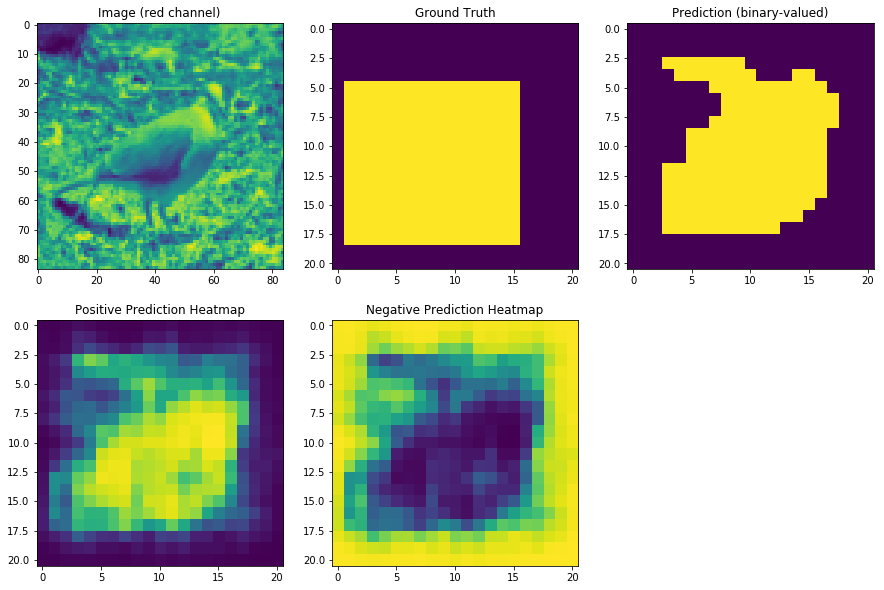

In [15]:
# Enter a number between 0 and 74
n = 20

m = n+evalway*trainshot
pl.figure(figsize=(15,10))
pl.subplot(2,3,1)
pl.imshow(inp[m][0].data.cpu().numpy())
pl.title("Image (red channel)")

pl.subplot(2,3,2)
t = targ[n].squeeze()
pl.imshow(t.data.cpu().squeeze().numpy())
pl.title("Ground Truth")

pl.subplot(2,3,3)
_,p = torch.max(pred[n],-1)
pl.imshow(p.data.cpu().squeeze().numpy())
pl.title("Prediction (binary-valued)")

pl.subplot(2,3,4)
pl.imshow(pred[n,:,:,1].data.cpu().squeeze().numpy())
pl.title("Positive Prediction Heatmap")

pl.subplot(2,3,5)
pl.imshow(pred[n,:,:,0].data.cpu().squeeze().numpy())
pl.title("Negative Prediction Heatmap")

intersection = (p*t).sum()
union = (1-(1-t)*(1-p)).sum()
print("Intersecting pixels: ", intersection.item())
print("Union pixels: ", union.item())
print("IoU: ", intersection.item()/union.item())